#Description

notebook to segment foci using otsu-thresholding and watershed/random walker

currently works for 3D. slight adjustment needed for single-plane (2D) data.

<hr>

# References
https://scikit-image.org/skimage-tutorials/lectures/three_dimensional_image_processing.html

## segmentation
- https://scipy-lectures.org/packages/scikit-image/#histogram-based-method-otsu-thresholding

- https://scipy-lectures.org/packages/scikit-image/#labeling-connected-components-of-a-discrete-image

- https://scipy-lectures.org/packages/scikit-image/#watershed-segmentation

- https://scipy-lectures.org/packages/scikit-image/#random-walker-segmentation


# Object design

- object name:
- attributes:
        identifier (arbitrary)
        
        #general
        img_matrix (path)
        binary_matrix (ndarray)
        label_matrix (ndarray)

        #binarisation - settings
        binarised_channel_idx (int)
        contrast args: {minq, maxq, full_stack}
        smooth args: {kernel, erosion, dilation}           
        
        #instance segmentation - settings
        algo: ['none', 'watershed', 'random_walker']


# Notebook initialisation

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount=True)

from datetime import datetime
import os

import copy
import skimage
import matplotlib.pyplot as plt
import numpy as np
import cv2
import numpy.ma as ma
import pandas as pd

#from cellpose.utils import outlines_list

from skimage.segmentation import watershed, random_walker
from skimage import morphology
from skimage import measure
from skimage.feature import peak_local_max
from scipy import ndimage

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Custom colormap
- gradient colormaps going from black to
1. red `redmap`
2. green `greenmap`
3. blue `bluemap`

Useful for plotting the channels separately.

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
#https://stackoverflow.com/questions/57268627/matplotlib-color-gradient-between-two-colors

colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
redmap = LinearSegmentedColormap.from_list(
        "Black2Red", colors, N=100)

colors = [(0, 0, 0), (0, 1, 0)] # first color is black, last is green
greenmap = LinearSegmentedColormap.from_list(
        "Black2Green", colors, N=100)

colors = [(0, 0, 0), (0, 0, 1)] # first color is black, last is blue
bluemap = LinearSegmentedColormap.from_list(
        "Black2Blue", colors, N=100)

rgb_map = {0:redmap, 1:greenmap, 2:bluemap}

# Custom functions

## pre-processing: image enhancement

In [ ]:
def increase_exposure(img_matrix, q=(0.005, 0.995), show=True, figsize=(10,10)):
    """Increase contrast between pixels by clipping extremes.

    Args:
        img_matrix (ndarray): 2D or 3D image matrix
        q (tup of 2 floats): min-max percentile range to retain. Default:
                             (0.005, 0.995)

    Returns:
        ndarray, enhanced img_matrix

    https://scikit-image.org/skimage-tutorials/lectures/three_dimensional_image_processing.html
    """
    vmin, vmax = np.quantile(img_matrix, q=q)


    #mask = (img_matrix >= vmin) & (img_matrix <= vmax)
    #img_enhanced = np.where(mask, img_matrix, 0)

    img_enhanced = skimage.exposure.rescale_intensity(
        img_matrix,
        in_range=(vmin, vmax),
        out_range=np.int8)

    if show: #plot original and enhanced img next to each other
        if len(img_enhanced.shape) == 2:
            fig, axes = plt.subplots(1,2, figsize=figsize)
            axes[0].imshow(img_matrix, cmap='gray')
            axes[0].set_title("original")

            axes[1].imshow(img_enhanced, cmap='gray')
            axes[1].set_title(f" increased contrast ({q[0]} - {q[1]})")

            for ax in axes: ax.axis("off")
            plt.tight_layout()
            plt.show();

        else: #show range, steps of 10
            for iplane in np.arange(0, img_matrix.shape[0], 10):
                fig, axes = plt.subplots(1,2, figsize=figsize)
                axes[0].imshow(img_matrix[iplane, :,:], cmap='gray')
                axes[0].set_title("original")

                axes[1].imshow(img_enhanced[iplane, :, :], cmap='gray')
                axes[1].set_title(f" increased contrast ({q[0]} - {q[1]})")

                for ax in axes: ax.axis("off")

                plt.suptitle(f"iplane = {iplane}", y=0.8)
                plt.tight_layout()
                plt.show();

    return img_enhanced

def smooth(binary_matrix, kernel_size=(2,2), erode=2, dilate=2):
    """ Smooth edges using erosion and dilation

    Args:
        binary_matrix (ndarray): 2D or 3D matrix. If a 3D matrix is provided,
                                 Each z will be smoothed separately
    """
    if len(binary_matrix.shape) not in [2,3]:
        raise ValueError("Provided binary matrix has dimensions"  +
                         f"{binary_matrix.shape}. Only 2D and 3D matrices " +
                         "are supported.")

    kernel = np.ones(kernel_size, np.uint8)

    #smoothing, 2D
    if len(binary_matrix.shape) == 2:
        binary_matrix_smoothed = cv2.erode(binary_matrix.astype('uint8'),
                                           kernel, iterations=erode)
        binary_matrix_smoothed = cv2.dilate(binary_matrix_smoothed.astype('uint8'),
                                            kernel, iterations=dilate)

    #smoothing, 3D
    if len(binary_matrix.shape) == 3:
        binary_matrix_smoothed = copy.deepcopy(binary_matrix)
        for iplane in range(binary_matrix.shape[0]):
            single_plane = binary_matrix[iplane,:,:]
            single_plane_smoothed = cv2.erode(single_plane.astype('uint8'),
                                              kernel, iterations=erode)
            single_plane_smoothed = cv2.dilate(single_plane_smoothed.astype('uint8'),
                                               kernel, iterations=dilate)
            binary_matrix_smoothed[iplane, :, :] = single_plane_smoothed

    return binary_matrix_smoothed

## Segmentation

### semantic segmentation

In [ ]:
def binarise_with_otsu(img_matrix, mask_matrix=None):
    """

    Args:
        img_matrix (ndarray): 2D or 3D image matrix.
        mask_matrix (ndarray, optional): 2D or 3D label matrix. if provided,
                                         only regions within labels are
                                         considered for otsu thresholding.

    Returns:
        Binary matrix with same dimensions as img_matrix.
    """
    if isinstance(mask_matrix, np.ndarray): #otsu only within labelled regions
        print("OTSU WITHIN REGIONS")
        img_labelled_regions = img_matrix[mask_matrix != 0]
        otsu_threshold = skimage.filters.threshold_otsu(img_labelled_regions)
    else: #otsu on entire img
        print("OTSU OUTSIDE REGIONS")
        otsu_threshold = skimage.filters.threshold_otsu(img_matrix)

    return img_matrix > otsu_threshold

### instance segmentation

In [ ]:
def binarised2label(binary_matrix, channel_matrix=None, algorithm='watershed', compactness=0, beta=130):
    """convert a 2D binarised matrix into distinct labels

    Args:
        binary_matrix (ndarray): 2D matrix
        channel_matrix: ndarray, required for random walker
        algorithm (str): ['none', 'watershed', 'random_walker']

        compactness: used in watershed
        beta: used in random_walker
    Returns:
        label matrix
    """
    if algorithm not in ['none', 'watershed', 'random_walker']:
        raise ValueError(f'Algorithm {algorithm} not recognised.')

    if algorithm=='none':
        return measure.label(binary_matrix, background=0)

    #markers, used in both watershed and random walker
    distance = ndimage.distance_transform_edt(binary_matrix)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((2, 2)), labels=binary_matrix)
    markers = morphology.label(local_maxi)

    if algorithm == 'watershed':
        return watershed(-distance, markers, mask=binary_matrix, compactness=compactness)

    if algorithm == 'random_walker':
        markers[np.where(binary_matrix == 0)] = -1 #convert bg pixels (0) into -1 (i.e. rw ignores these pixels)
        return random_walker(channel_matrix, markers, beta=beta)


In [ ]:
def binarised2label_3d(binary_matrix, channel_matrix=None, algorithm='watershed', compactness=0, beta=130):
    """segment every plane of a 3d binary matrix


    returns:
        3d label matrix with sequential labels. every label is 1 plane wide.
    note:
        -
    """
    nplanes, x, y = binary_matrix.shape

    full_label_matrix = np.empty(shape=(0, x, y))
    max_id = 1

    for iplane in range(nplanes):
        binary_plane_matrix = binary_matrix[iplane, :,:]
        img_plane_matrix = channel_matrix[iplane,:,:]

        label_plane_matrix = binarised2label(binary_plane_matrix, img_plane_matrix, algorithm)
        label_plane_matrix, _, _ = skimage.segmentation.relabel_sequential(label_plane_matrix, offset = max_id)
        full_label_matrix = np.append(full_label_matrix, [label_plane_matrix], axis=0)

        max_id = np.unique(label_plane_matrix)[-1] + 1

    return full_label_matrix

### plot segmentation

In [ ]:
def plot_labels(img, label_matrices, label_names, more_labels=[], label_color=['r'], suptitle='', plot_as_outlines=True):
    """
    label_matrices (list of np.arrays): 2d matrices
    label_names (list of str): used as title in plots
    more_labels (list of np.arrays, optional): additional labels to overlay

    returns:
        a fig of subplots
        0. original
        1+. original + label overlay (+ optional other labels)
    """
    nlabels = len(label_matrices)
    fig, axes = plt.subplots(1,nlabels+1, figsize=(5*nlabels+1,5))

    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("original")

    for i, label_matrix in enumerate(label_matrices,1): #foci
        axes[i].imshow(img, cmap='gray')

        #plot outlines
        labels = [label_matrix] + more_labels
        for icolor, label in enumerate(labels):
            if plot_as_outlines:
                for o in outlines_list(label):
                    axes[i].plot(o[:,0], o[:,1], color=label_color[icolor],linewidth=0.7, alpha=1)
            else:
                axes[i].imshow(label_matrix, cmap='nipy_spectral', interpolation='nearest', alpha=1)

        axes[i].set_title(f"{label_names[i-1]} (n={len(np.unique(label_matrix))})") #?? does not seem to work??
        axes[i].set_title(f"{label_names[i-1]}")

    for ax in axes:
        ax.axis("off")

    plt.suptitle(suptitle,y=0.9)
    plt.show();

    return fig

def show_mask(label_matrix, img_matrix, selected_regionids, alpha=0.5, zoom_in=True, padding=0):
    """

    Args:
        zoom_in (bool, optional): only works if 1 regionid is provided.
    """
    label_copy = copy.deepcopy(label_matrix)
    img_copy = copy.deepcopy(img_matrix)

    #show single region
    if isinstance(selected_regionids, list):
        label_copy[~np.isin(label_copy, selected_regionids)] = 0

    # zoom in
    if zoom_in and len(selected_regionids) == 1:
        x0,y0,x1,y1 = skimage.measure.regionprops(label_copy)[0].bbox

        xmax = label_copy.shape[0]
        ymax = label_copy.shape[1]
        x0 = (x0 - padding if x0 - padding > 0 else 0)
        y0 = (y0 - padding if y0 - padding > 0 else 0)
        x1 = (x1 + padding if x1 + padding < xmax else xmax)
        y1 = (y1 + padding if y1 + padding < ymax else ymax)

        label_copy = label_copy[x0:x1, y0:y1]
        img_copy = img_copy[x0:x1, y0:y1]

    _ = skimage.color.label2rgb(label=label_copy,
                                image=img_copy,
                                bg_color=None,
                                alpha=alpha)
    plt.imshow(_);

### temporary (remove later)

In [ ]:
#utils
def outlines_list(mask_matrix):
    """ get outlines of masks as a list to loop over for plotting

    Notes:
        outlines_list() cellpose v2.2.2
    """
    print("DEV: REMOVE outlines_list def FROM FINAL. USE outlines_list from cellpose.utils import")
    outline_px =[]

    mask_ids = list(np.unique(mask_matrix))
    if 0 in mask_ids:
        mask_ids.remove(0)

    for mask_id in mask_ids:
        mask_px = mask_matrix == mask_id
        contours = cv2.findContours(mask_px.astype(np.uint8),
                                    mode=cv2.RETR_EXTERNAL,
                                    method=cv2.CHAIN_APPROX_NONE)[-2]

        cmax = np.argmax([c.shape[0] for c in contours])
        pix = contours[cmax].astype(int).squeeze()
        if len(pix)>4:
            outline_px.append(pix)
        else:
            outline_px.append(np.zeros((0,2)))
    return outline_px



### Custom channel names
Indicate the channels

In [ ]:
channel_names = {0:"DAPI",
                 1:"LaminB1",
                 2:"H3K4me3"}

- iplane=40:
the segmentation on the left mid side is a good example of using DAPI as a quality control measure: the foci pass predicted nuclear borders.


# Data loading

**input**<br>
- img_path
- masks_path

**returns**
- img
- masks
- nplanes
- nchannels

img shape (Z x X x Y x nchannels):  (80, 250, 250, 3)
masks shape (Z x X x Y):  (80, 250, 250)
DEV: REMOVE outlines_list def FROM FINAL. USE outlines_list from cellpose.utils import


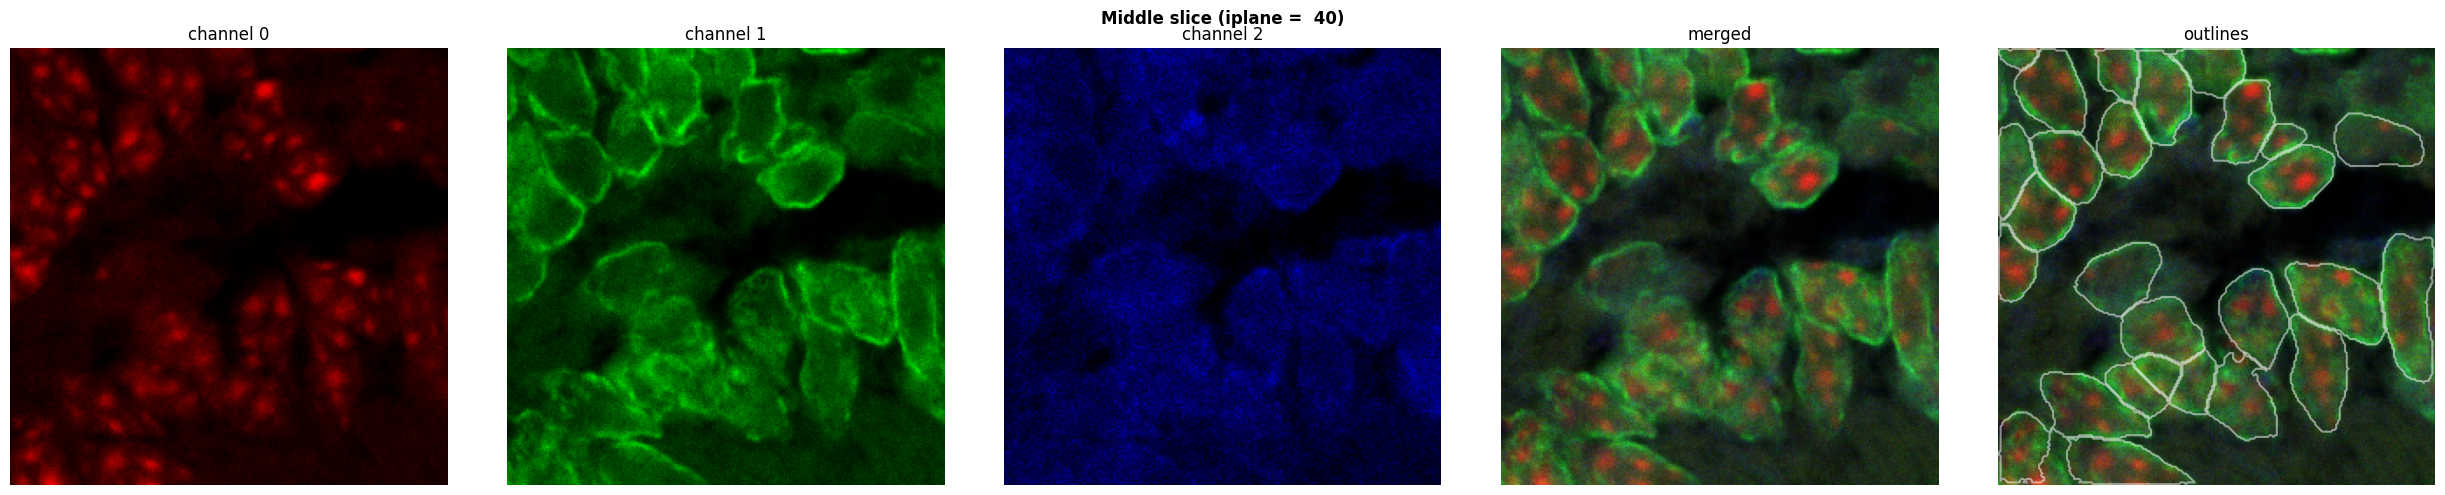

In [ ]:
#@markdown **Intensity channels and nuclear segmentation**
#@markdown <br>*also works for cellular segmentations.
img_path="/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/00_raw_data/full_zstacks/sub/SPE_20230327_D25_x600-850_y550-800.tif" #@param {type:"string"}
masks_path="/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/04_cellpose3D/D25_sub/3D_masks_mode-stitched2dmasks.tiff" #@param {type:"string"}
img = skimage.io.imread(img_path) #shape: (80, 250, 250, 3)
masks = skimage.io.imread(masks_path) #shape: (80, 250, 250)

print("img shape (Z x X x Y x nchannels): ", img.shape)
print("masks shape (Z x X x Y): ", masks.shape)

nplanes = img.shape[0]
nchannels = img.shape[-1]

#init
iplane = round(nplanes/2)
stacked_plane = np.dstack(tuple(img[iplane,:,:,i] for i in range(nchannels)))
imasks = masks[iplane, :,:]

#visualisation
fig, axes = plt.subplots(1,nchannels+2,figsize=(5*(nchannels+2),5))

for i in range(nchannels):
    axes[i].imshow(img[iplane,:,:,i], cmap=rgb_map.get(i))
    axes[i].set_title(f"channel {i}")

axes[-2].imshow(stacked_plane); axes[-2].set_title(f"merged")

axes[-1].imshow(stacked_plane); axes[-1].set_title("outlines")
for o in outlines_list(imasks):
    axes[-1].plot(o[:,0], o[:,1], color='w', alpha=0.5)

for ax in axes:
    ax.axis("off")

plt.suptitle(f"Middle slice (iplane =  {iplane})", weight="bold")
plt.tight_layout()
plt.show();

# Parameter selection

**Description**<br>
selection based on
- inspection of a few planes (user specifies the iplanes -- here: top, middle, bottom)
- whether foci are correctly separated in small subsections


**Output**<br>
for each selected iplane
1. merged intensity matrix
2. selected channel intensity matrix
3. binarised matrix
4. smoothed matrix
5. label matrix - rainbow


Erosion and dilation

**user input**
- kernel_size (tup (int, int)) - the smaller the kernel size, the more details are retained. Increasing kernel size likely leads to merging of regions.
- erode, dilate (int) - number of iterations for the erosion and dilation process.

In [ ]:
#@markdown **data**
selected_channel = 0 #@param {type:"number"}

#@markdown **contrast options**
min_q = 0.65 # @param {type:"slider", min:0, max:1, step:0.001}
max_q = 1 # @param {type:"slider", min:0, max:1, step:0.001}

#@markdown **otsu options**
otsu_within_regions = True #@param {type:"boolean"}
mask_matrix = (masks if otsu_within_regions else None)

#@markdown **smooth options**
kernel_size=(2,2) #@param {type:"raw"}
erode = 2 #@param {type:"number"}
dilate = 2 #@param {type:"number"}

#@markdown **segmentation options**<br>
#@markdown If algorithm: watershed, provide `compactness`.<br>
#@markdown If random_walker, provide `beta`.
algorithm = "watershed" #@param ['none', 'watershed', 'random_walker']
compactness = 0 # @param {type:"number"}
beta = 0 #@param {type:"number"}

#@markdown **visualisation options**
iplanes_plot = [0, round(nplanes/2), nplanes-1] #@param {type:"raw"}

#@markdown **export**
output_dir = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/05_foci_segmentation/D25_test_subsection" #@param {type:"string"}

#@markdown [code: printing options]
options_dict = {
    "data": {
        "img_path": img_path,
        "mask_path": masks_path
    },
    "selected_channel": selected_channel,
    "contrast_options": {
        "min_q": min_q,
        "max_q": max_q
    },
    "otsu_options": {
        "otsu_within_regions": otsu_within_regions
    },
    "smooth_options": {
        "kernel_size": kernel_size,
        "erode": erode,
        "dilate": dilate
    },
    "segmentation_options": {
        "algorithm": algorithm,
        "compactness": compactness,
        "beta": beta
    },
    "visualization_options": {
        "iplanes_plot": iplanes_plot
    }
}

print("Settings:")
for key, value in options_dict.items():
    print(f"\t{key}: {value}")

if len(output_dir)>0 and not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"\t{datetime.now()}\tMade a directory: {output_dir}")

print(f"\nOutput will be saved in '{output_dir}'")


Settings:
	data: {'img_path': '/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/00_raw_data/full_zstacks/sub/SPE_20230327_D25_x600-850_y550-800.tif', 'mask_path': '/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/04_cellpose3D/D25_sub/3D_masks_mode-stitched2dmasks.tiff'}
	selected_channel: 0
	contrast_options: {'min_q': 0.65, 'max_q': 1}
	otsu_options: {'otsu_within_regions': True}
	smooth_options: {'kernel_size': (2, 2), 'erode': 2, 'dilate': 2}
	segmentation_options: {'algorithm': 'watershed', 'compactness': 0, 'beta': 0}
	visualization_options: {'iplanes_plot': [0, 40, 79]}

Output will be saved in '/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/05_foci_segmentation/D25_test_subsection'


## Binarisation (Semantic segmentation)

2024-04-16 12:01:25.834018	Started processing
2024-04-16 12:01:25.834798		Increasing exposure
2024-04-16 12:01:25.943928		Binarising with otsu thresholding
OTSU WITHIN REGIONS
2024-04-16 12:01:25.960015		Smoothing
2024-04-16 12:01:25.968803	Finished processing


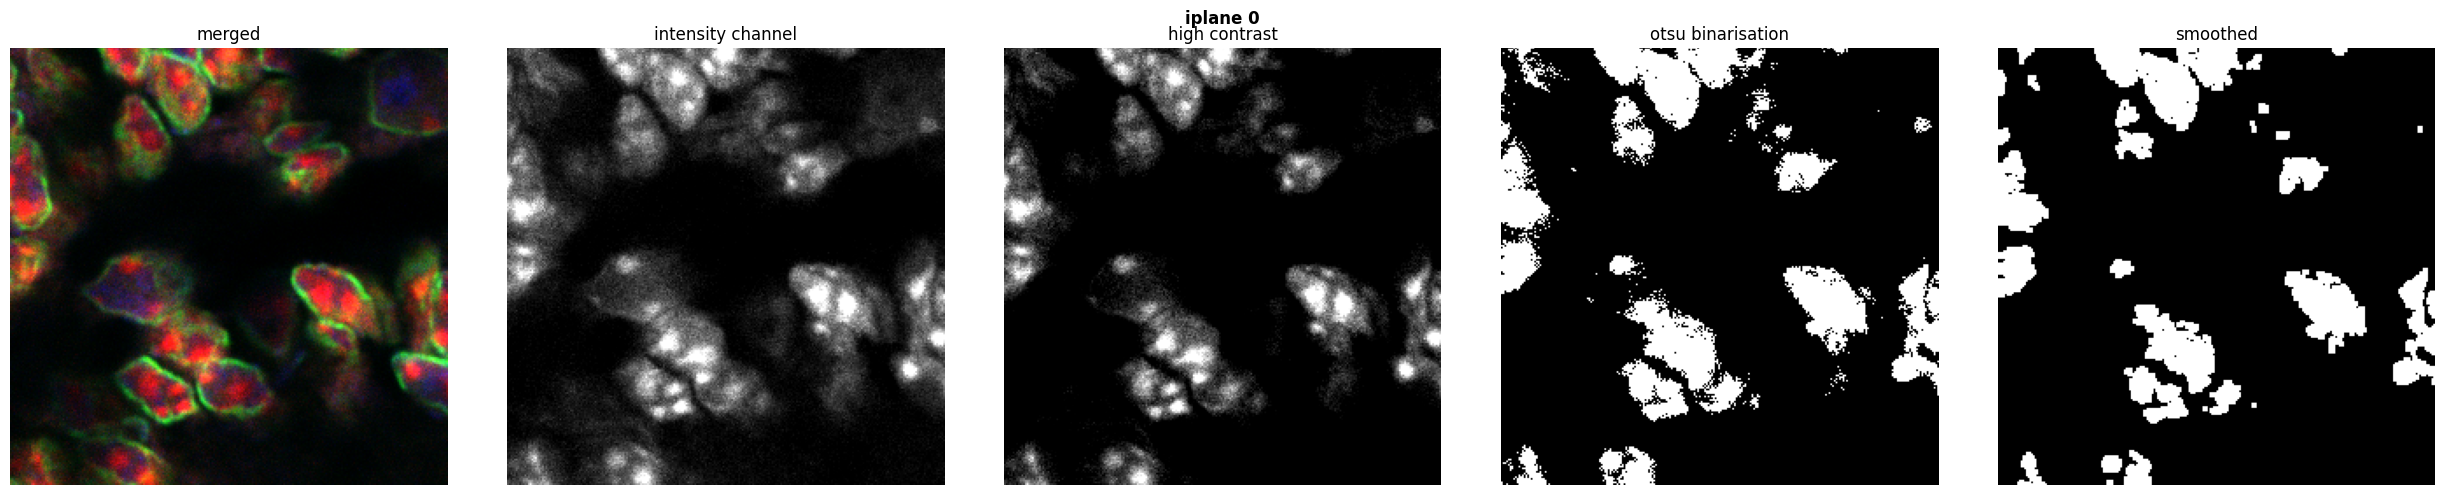

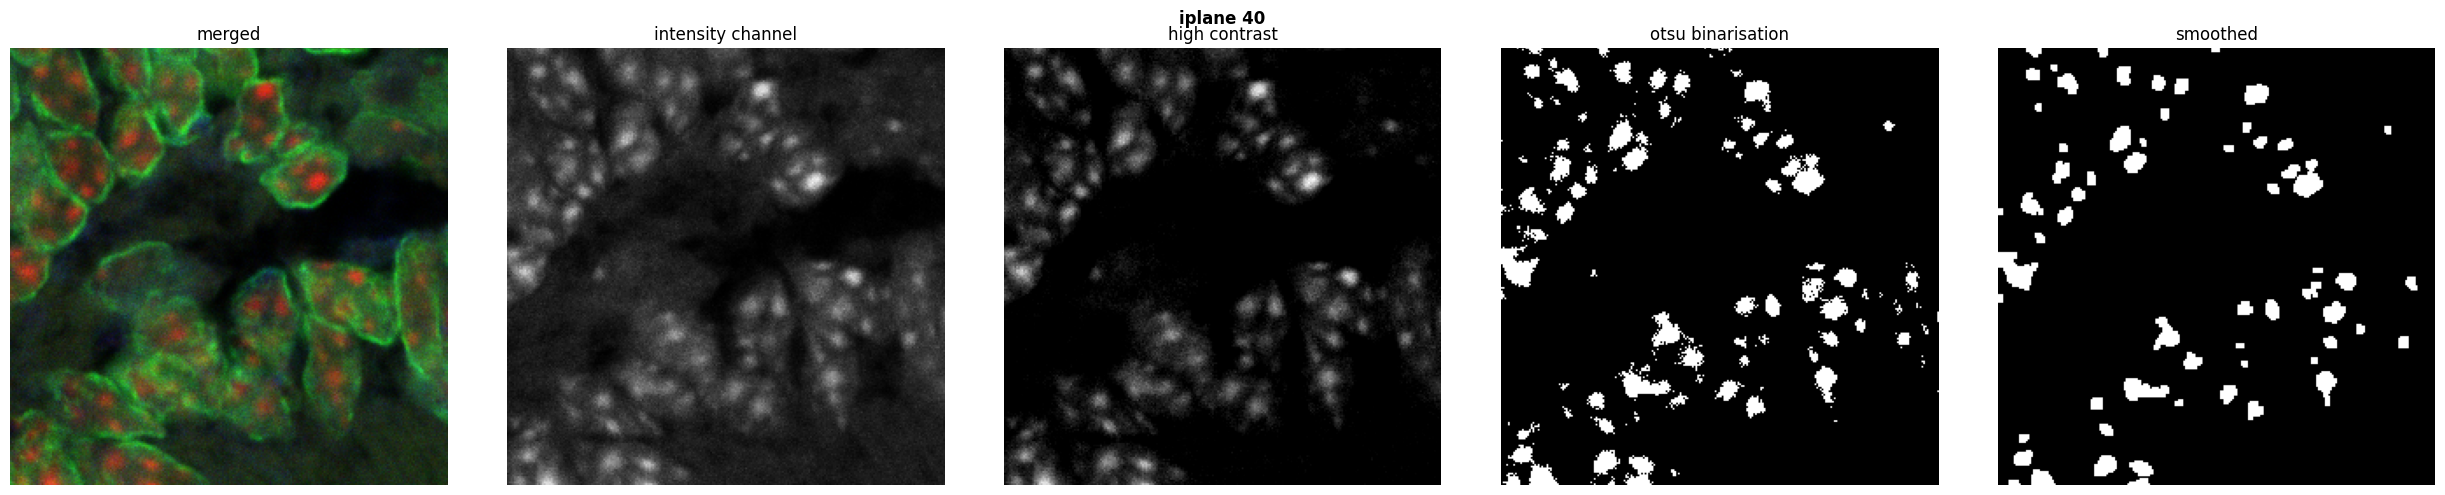

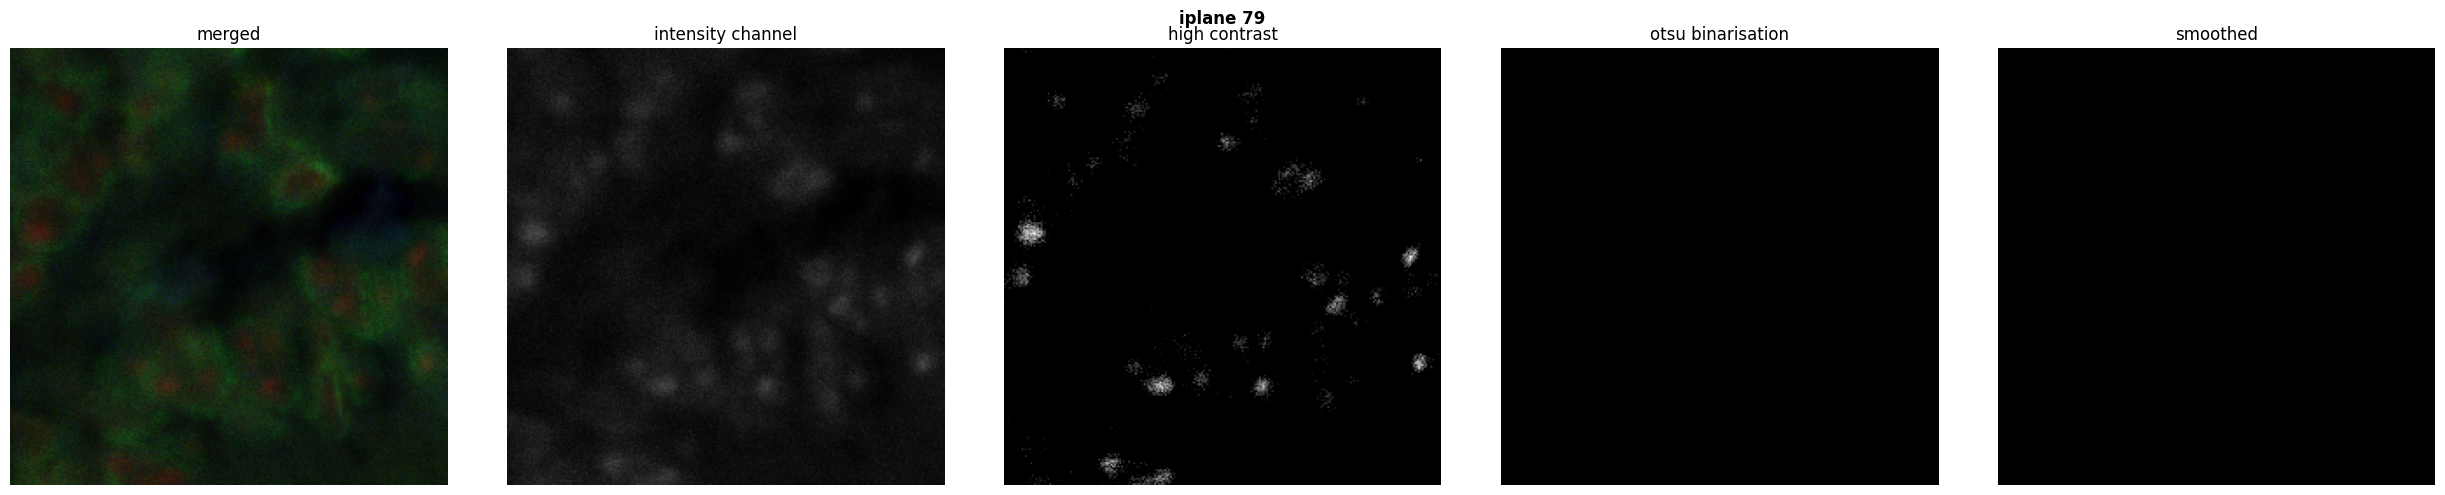

In [ ]:
#@markdown [code]
# process
print(f"{datetime.now()}\tStarted processing")
channel_matrix = img[:,:,:,selected_channel]

if (min_q, max_q) != (0,1):
    print(f"{datetime.now()}\t\tIncreasing exposure")
    contrast_matrix = increase_exposure(channel_matrix, (min_q, max_q), show=False)
else:
    contrast_matrix = copy.deepcopy(channel_matrix)

print(f"{datetime.now()}\t\tBinarising with otsu thresholding")
otsu_matrix = binarise_with_otsu(contrast_matrix, mask_matrix)

print(f"{datetime.now()}\t\tSmoothing")
smooth_matrix = smooth(otsu_matrix, kernel_size, erode, dilate)

print(f"{datetime.now()}\tFinished processing")

# plot
for iplane_plot in iplanes_plot:
    stacked_plane = np.dstack(tuple(img[iplane_plot,:,:,i] for i in range(nchannels)))

    fig, axes = plt.subplots(1,5,figsize=(25,5))

    axes[0].set_title("merged")
    axes[0].imshow(stacked_plane)

    axes[1].set_title("intensity channel")
    axes[1].imshow(channel_matrix[iplane_plot, :,:], cmap='gray', vmin=0, vmax=255)

    axes[2].set_title("high contrast")
    axes[2].imshow(contrast_matrix[iplane_plot, :,:], cmap='gray')#, vmin=0, vmax=255)

    axes[3].set_title("otsu binarisation")
    axes[3].imshow(otsu_matrix[iplane_plot, :,:], cmap='gray')

    axes[4].set_title("smoothed")
    axes[4].imshow(smooth_matrix[iplane_plot, :,:], cmap='gray')

    for ax in axes:
        ax.axis("off")

    plt.suptitle(f"iplane {iplane_plot}", weight="bold")
    plt.tight_layout()

    plt.show();

## Instance segmentation

**Instructions**<br>
Continue if the binarisation looks good.

In [ ]:
print(f"{datetime.now()}\t\tInstance segmentation")
label_matrix = binarised2label_3d(smooth_matrix, channel_matrix, algorithm, compactness, beta)
print(f"{datetime.now()}\t\tFinished segmentation")

2024-04-16 12:02:08.177207		Instance segmentation


<ipython-input-83-8ffdbacbde9e>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((2, 2)), labels=binary_matrix)


2024-04-16 12:02:21.643305		Finished segmentation


DEV: REMOVE outlines_list def FROM FINAL. USE outlines_list from cellpose.utils import


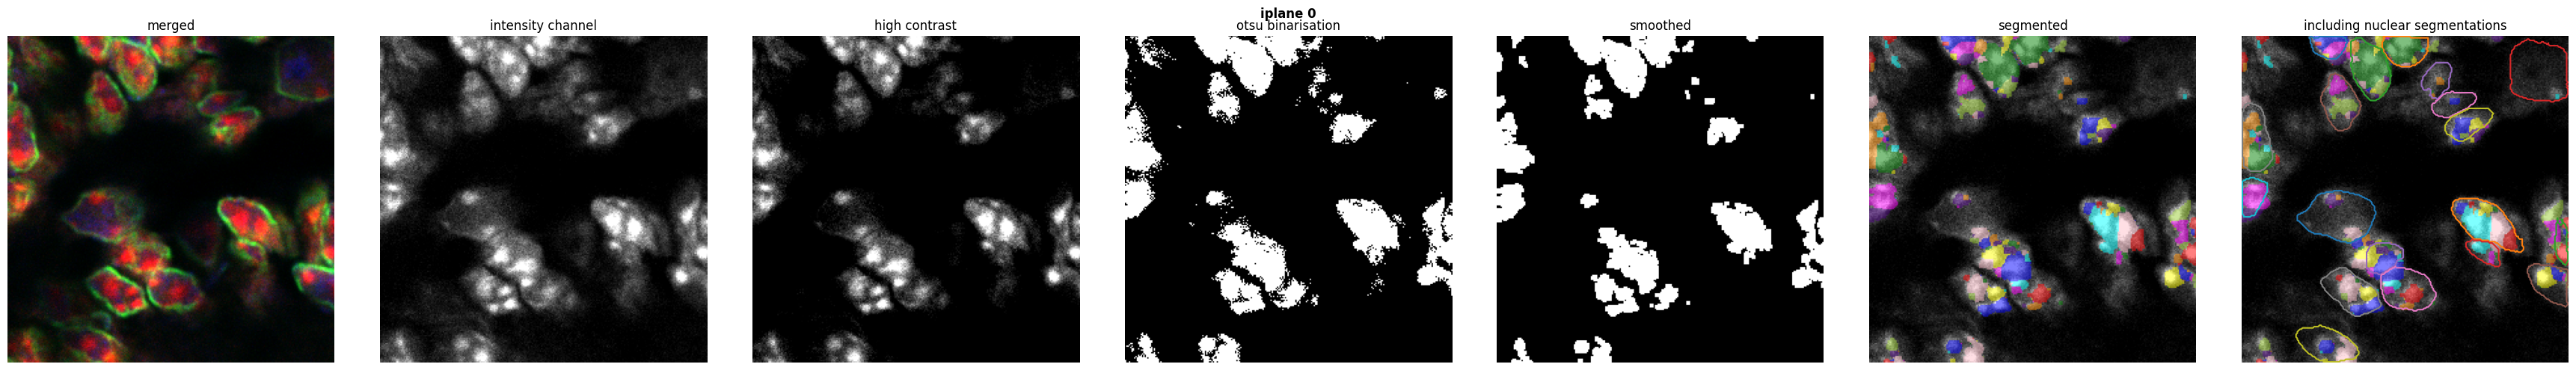

DEV: REMOVE outlines_list def FROM FINAL. USE outlines_list from cellpose.utils import


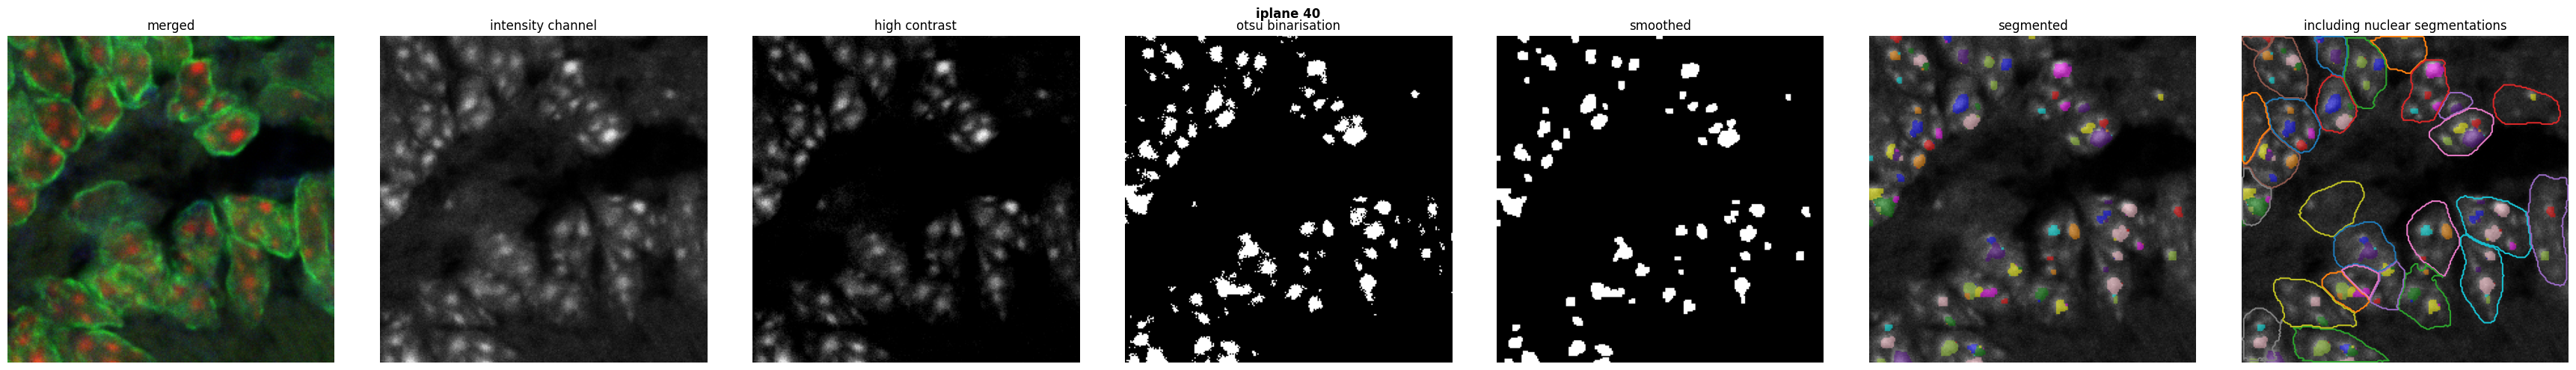

DEV: REMOVE outlines_list def FROM FINAL. USE outlines_list from cellpose.utils import


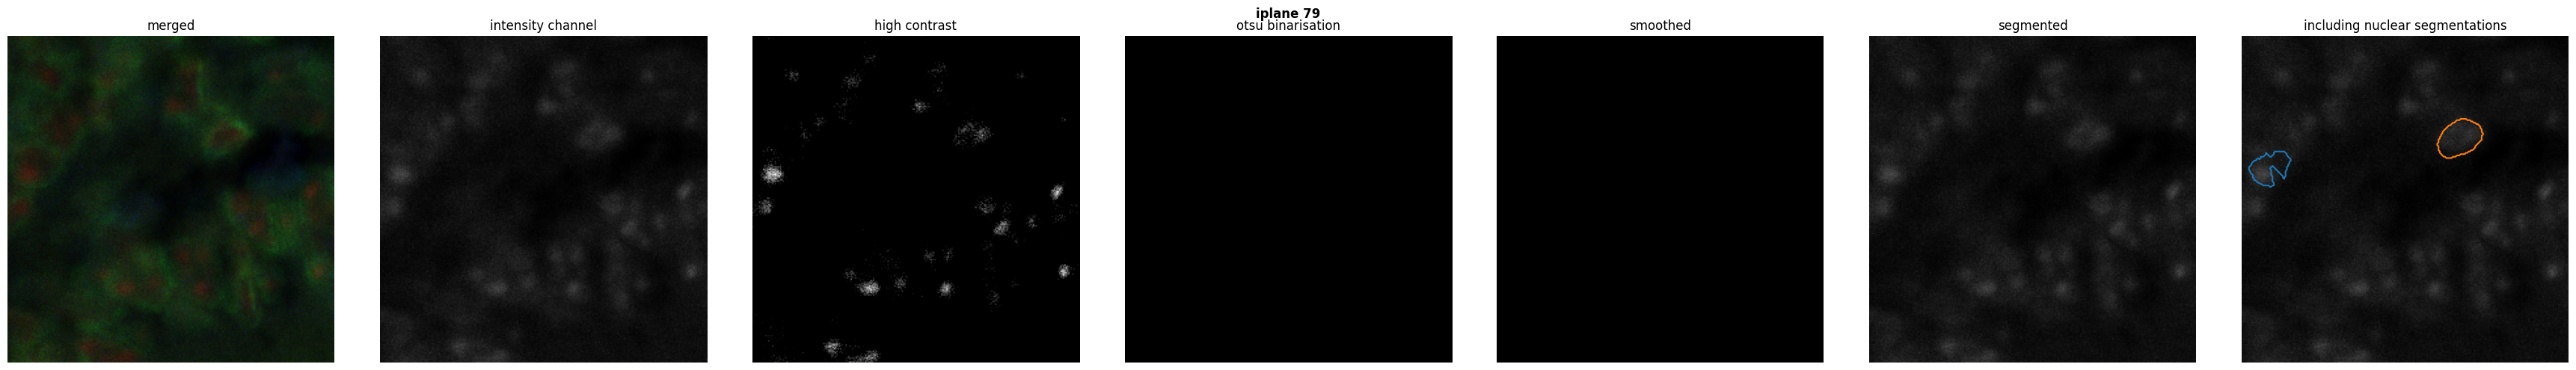

In [ ]:
#@markdown [code]
alpha = 0.5 # @param {type:"slider", min:0, max:1, step:0.1}
save=True #@param {type:"boolean"}

bg_id = np.unique(label_matrix)[0]
#plot
for iplane_plot in iplanes_plot:
    stacked_plane = np.dstack(tuple(img[iplane_plot,:,:,i] for i in range(nchannels)))

    fig, axes = plt.subplots(1,7,figsize=(35,5))

    axes[0].set_title("merged")
    axes[0].imshow(stacked_plane)

    axes[1].set_title("intensity channel")
    axes[1].imshow(channel_matrix[iplane_plot, :,:], cmap='gray', vmin=0, vmax=255)

    axes[2].set_title("high contrast")
    axes[2].imshow(contrast_matrix[iplane_plot, :,:], cmap='gray')

    axes[3].set_title("otsu binarisation")
    axes[3].imshow(otsu_matrix[iplane_plot, :,:], cmap='gray')

    axes[4].set_title("smoothed")
    axes[4].imshow(smooth_matrix[iplane_plot, :,:], cmap='gray')

    for i in [5,6]:
        #axes[i].imshow(channel_matrix[iplane_plot, :,:], cmap='gray')
        #axes[i].imshow(label_matrix[iplane_plot, :,:])


        axes[i].imshow(skimage.color.label2rgb(label=label_matrix[iplane_plot, :,:],
                                    image=channel_matrix[iplane_plot, :,:],
                                    bg_label=bg_id,
                                    bg_color=None,
                                    kind='overlay',
                                    alpha=alpha))

    axes[5].set_title("segmented")

    axes[6].set_title("including nuclear segmentations")
    for o in outlines_list(masks[iplane_plot, :,:]):
        axes[6].plot(o[:,0], o[:,1])

    for ax in axes:
        ax.axis("off")

    plt.suptitle(f"iplane {iplane_plot}", weight="bold")
    plt.tight_layout()

    if save: plt.savefig(f"{output_dir}/{iplane_plot}_segmentation.png")
    plt.show();

# From 2D to 3D

dev: in progress. Using mask_merger.ipynb

# Nucleus filtering
remove nucleus masks if foci are on nucleus borders.

for each label, check which nucleus id are in the label region

adjust get_overlapping_masks to include plane_id column

In [ ]:
def get_comparison_ids_within_region(reference_matrix, reference_id, comparison_matrix):
    search_window = comparison_matrix[np.where(reference_matrix == reference_id)]
    comparison_ids = list(np.unique(search_window))

    return comparison_ids

def get_overlapping_masks(reference_object, comparison_object,
                          reference_name='reference', comparison_name='comparison'):
    """Determine which masks from two matrices overlap with each other

    Args:
        reference_object: ndarray reference matrix.
        comparison_object:  ndarray comparison matrix.

    Returns:
        pd.DataFrame: A DataFrame containing information about overlapping masks.
            The columns are as follows:
                - reference_id: ID of the mask in the reference matrix.
                - comparison_id: ID of the mask in the comparison matrix.
                - reference_size: Size of the mask in the reference matrix.
                - comparison_size: Size of the mask in the comparison matrix.
                - intersection_size: Size of the intersection between the masks.
                - union_size: Size of the union between the masks.
                - jaccard_index: Jaccard index calculated between the masks.
                - dice_coefficient: Dice coefficient calculated between the masks.
    """

    data_list = []

    reference_ids = list(np.unique(reference_object))
    reference_ids.remove(0)

    for reference_id in reference_ids:
        reference_px = np.column_stack(np.where(reference_object == reference_id))
        reference_tuples = list(map(tuple, reference_px))

        match_found=False

        #get comparison_ids within the region (computation efficiency)
        comparison_ids = get_comparison_ids_within_region(reference_object,
                                                          reference_id,
                                                          comparison_object)

        if 0 in comparison_ids:
            comparison_ids.remove(0)

        for comparison_id in comparison_ids:
            comparison_px = np.column_stack(np.where(comparison_object == comparison_id))
            compare_tuples = list(map(tuple, comparison_px))

            intersection_px = set(reference_tuples).intersection(set(compare_tuples))


            if len(intersection_px) > 0 :
                match_found = True

                union_px = set(reference_tuples).union(set(compare_tuples))

                jaccard_index = len(intersection_px) / len(union_px)
                dice_coefficient = (2 * len(intersection_px)) / (len(reference_px) + len(comparison_px))

                data = {f"{reference_name}_id": reference_id ,
                        f"{comparison_name}_id": comparison_id,
                        f"{reference_name}_size": len(reference_px) ,
                        f"{comparison_name}_size": len(comparison_px),
                        "intersection_size": len(intersection_px),
                        "union_size": len(union_px),
                        "jaccard_index": jaccard_index,
                        "dice_coefficient": dice_coefficient}
                data_list.append(data)

        if not match_found:
            data = {f"{reference_name}_id": reference_id ,
                    f"{comparison_name}_id": -1,
                    f"{reference_name}_size": len(reference_px),
                    f"{comparison_name}_size": -1,
                    "intersection_size": -1,
                    "union_size": -1,
                    "jaccard_index": -1,
                    "dice_coefficient": -1}
            data_list.append(data)

    df = pd.DataFrame(data_list)

    return df

In [ ]:
iplane = 40
reference_matrix = label_matrix[iplane,:,:]
comparison_matrix = mask_matrix[iplane, :,: ]
reference_id = np.unique(reference_matrix)[1] #4700

_ = get_overlapping_masks(reference_matrix, comparison_matrix,
                          reference_name='foci', comparison_name='nuclei')

_

foci_id  nuclei_id  foci_size  nuclei_size  intersection_size  \
0     4700.0         27         41         1450                  7   
1     4700.0         58         41          218                 32   
2     4701.0          1         28          628                 24   
3     4702.0          2         15          891                 15   
4     4703.0          1          4          628                  4   
..       ...        ...        ...          ...                ...   
119   4815.0         34         97          999                 51   
120   4816.0         19          1         1448                  1   
121   4817.0         19          1         1448                  1   
122   4818.0         19         36         1448                 36   
123   4819.0         34         19          999                 12   

     union_size  jaccard_index  dice_coefficient  
0          1484       0.004717          0.009390  
1           227       0.140969          0.247104  
2           632       0.037975          0.073171  
3           891       0.016835          0.033113  
4           628       0.006369          0.012658  
..          ...            ...               ...  
119        1045       0.048804          0.093066  
120        1448       0.000691          0.001380  
121        1448       0.000691          0.001380  
122        1448       0.024862          0.048518  
123        1006       0.011928          0.023576  

[124 rows x 8 columns]

In [ ]:
_[_['intersection_size']/_['foci_size'] > 0.3]

foci_id  nuclei_id  foci_size  nuclei_size  intersection_size  \
1     4700.0         58         41          218                 32   
2     4701.0          1         28          628                 24   
3     4702.0          2         15          891                 15   
4     4703.0          1          4          628                  4   
5     4704.0         27         15         1450                 15   
..       ...        ...        ...          ...                ...   
119   4815.0         34         97          999                 51   
120   4816.0         19          1         1448                  1   
121   4817.0         19          1         1448                  1   
122   4818.0         19         36         1448                 36   
123   4819.0         34         19          999                 12   

     union_size  jaccard_index  dice_coefficient  
1           227       0.140969          0.247104  
2           632       0.037975          0.073171  
3           891       0.016835          0.033113  
4           628       0.006369          0.012658  
5          1450       0.010345          0.020478  
..          ...            ...               ...  
119        1045       0.048804          0.093066  
120        1448       0.000691          0.001380  
121        1448       0.000691          0.001380  
122        1448       0.024862          0.048518  
123        1006       0.011928          0.023576  

[121 rows x 8 columns]

DEV: REMOVE outlines_list def FROM FINAL. USE outlines_list from cellpose.utils import
DEV: REMOVE outlines_list def FROM FINAL. USE outlines_list from cellpose.utils import


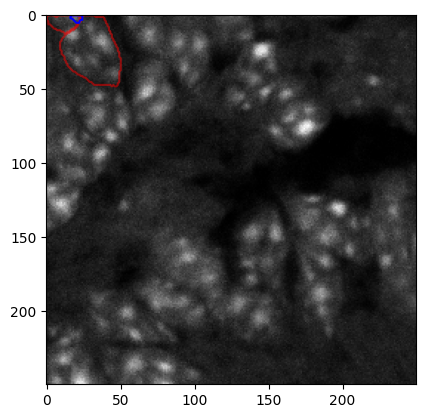

In [ ]:
filtered_foci_matrix = np.where(np.isin(reference_matrix, [reference_id]), reference_matrix, 0)
filtered_nucleus_matrix = np.where(np.isin(comparison_matrix, inspecting_nuclei_ids), comparison_matrix, 0)

plt.imshow(channel_matrix[iplane, :,:], cmap='gray')

for o in outlines_list(filtered_nucleus_matrix):
    plt.plot(o[:,0], o[:,1], color='r', alpha=0.5)
for o in outlines_list(filtered_foci_matrix):
    plt.plot(o[:,0], o[:,1], color='b')

## export

- json file with settings and filtering settings
- pngs of the results
- 2D label matrix
- 3D label matrix

In [ ]:
#json
import json

output_file_path = f"{output_dir}/.settings.json"
with open(output_file_path, 'w') as json_file:
    json.dump(options_dict, json_file, indent=4)

print(f"JSON file created at {output_file_path}")

JSON file created at /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/05_foci_segmentation/D25_test_subsection/.settings.json


In [ ]:
#2d label matrix
import tifffile

output_labels_path = f"{output_dir}/labels.tiff"
tifffile.imwrite(output_labels_path, label_matrix, bigtiff=True)

print(f"Matrix file created at {output_labels_path}")

Matrix file created at /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/05_foci_segmentation/D25_test_subsection/labels.tiff


# Show statistics
https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops

https://nl.mathworks.com/help/images/ref/regionprops.html

- per focus:<br>
        roundness vs area

In [ ]:
import pandas as pd
import math

In [ ]:
def calculate_roundness(region_mask):
    """Return the roundness of a 2D mask region.

    Args:
        region_mask

    notes:
        - props.perimeter is not used as it has the tendency to break when region_masks are small
        https://nl.mathworks.com/matlabcentral/answers/357994-perimeter-used-by-regionprops

    """
    roundness = (4 * math.pi * region_mask.area) / (region_mask.perimeter ** 2)
    return (-1 if roundness == float('inf') else roundness)

def calculate_ideal_perimeter(region_mask):
    ideal_radius = region_mask.equivalent_diameter_area / 2
    return (2 * math.pi * ideal_radius)

In [ ]:
props = skimage.measure.regionprops(selected_label_matrix)
props_df = pd.DataFrame(skimage.measure.regionprops_table(selected_label_matrix,
                                                          properties=['label',
                                                                      'area',
                                                                      'perimeter']))
# add circularity column
props_df['roundness'] = [calculate_roundness(regionmask) for regionmask in props]
#props_df['ideal_perimeter'] = [ideal_perimeter(regionmask) for regionmask in props]
#props_df['peri/ideal_peri'] = props_df['perimeter'] / props_df['ideal_perimeter']
#props_df['ideal_peri/peri'] = props_df['ideal_perimeter'] / props_df['perimeter']
props_df


<ipython-input-177-f49ccdd6c7f9>:12: RuntimeWarning: divide by zero encountered in scalar divide
  roundness = (4 * math.pi * region_mask.area) / (region_mask.perimeter ** 2)


label  area  perimeter  roundness
0       1    27  16.828427   1.198082
1       2    34  20.242641   1.042688
2       3    46  22.485281   1.143329
3       4     1   0.000000  -1.000000
4       5    23  15.414214   1.216452
5       6    40  23.656854   0.898164
6       7    63  29.656854   0.900120
7       8    34  19.071068   1.174732
8       9    58  27.071068   0.994551
9      10    42  22.242641   1.066808
10     11    15  12.000000   1.308997
11     12    46  23.414214   1.054408
12     13    21  14.242641   1.300913
13     14    15  11.414214   1.446802
14     15    66  28.485281   1.022146
15     16    36  19.656854   1.170804
16     17     9   8.000000   1.767146
17     18     9   8.000000   1.767146
18     19    29  17.414214   1.201711
19     20    31  18.242641   1.170567
20     21    28  17.656854   1.128603
21     22     1   0.000000  -1.000000
22     23    81  31.899495   1.000293
23     24    40  21.414214   1.096139
24     25    25  15.656854   1.281566
25     26    10   8.207107   1.865648
26     27    60  26.727922   1.055433
27     28     1   0.000000  -1.000000
28     29     1   0.000000  -1.000000
29     30    27  16.828427   1.198082

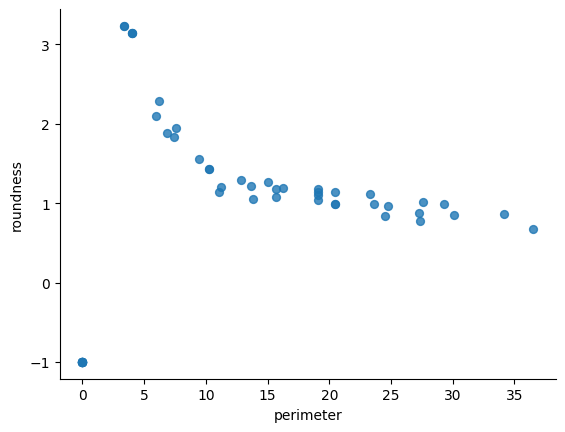

In [ ]:
# @title perimeter vs roundness

from matplotlib import pyplot as plt
props_df.plot(kind='scatter', x='perimeter', y='roundness', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

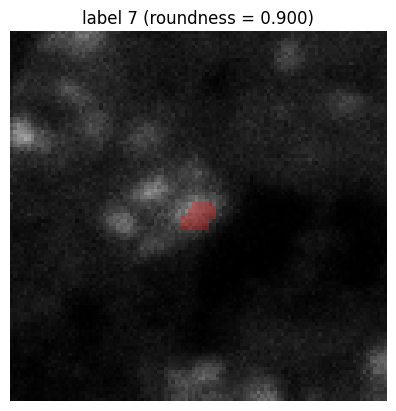

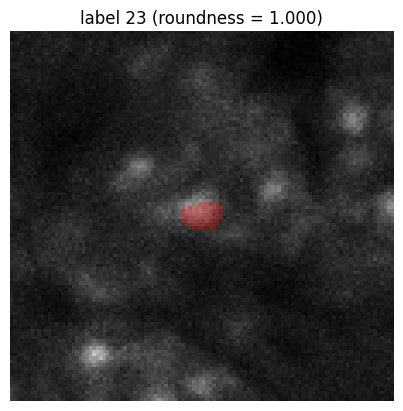

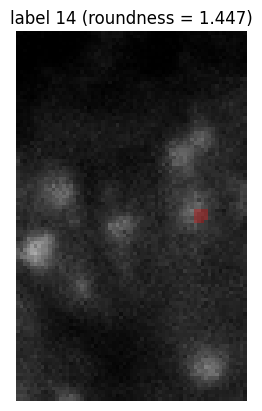

In [ ]:
iplane=60
ichannel=0

label_matrix = selected_label_matrix
img_matrix = img[iplane, :,:,ichannel]
alpha=0.3
zoom_in = True
padding = 50

#show single region
selected_regionids = [7, 23, 14]

for idx in selected_regionids:
    show_mask(label_matrix, img_matrix, [idx], alpha, zoom_in, padding)
    roundness = float(props_df.loc[props_df['label'] == idx, 'roundness'].iloc[0])
    plt.axis("off")
    plt.title(f"label {idx} (roundness = {roundness:.3f})");
    plt.show();


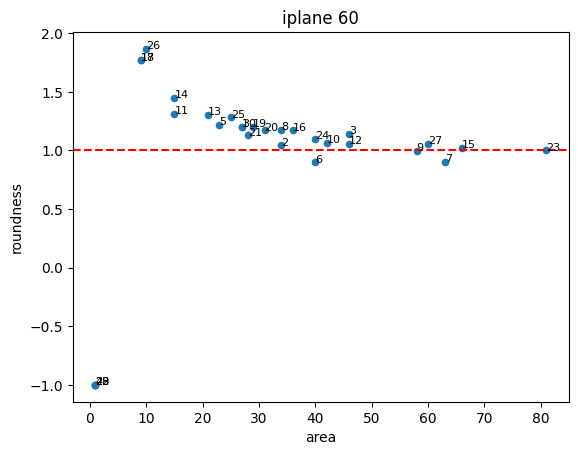

In [ ]:
props_df.plot.scatter(x='area', y='roundness')
for _, row in props_df.iterrows():
    plt.text(row['area'], row['roundness'], str(row['label'])[:-2], fontsize=8)
plt.axhline(y=1, color='r', linestyle='--')
plt.title(f"iplane {iplane}");


high `roundness`when area is small due to calculations of roundness.


Inspection each label


- x= iplane, y=area -- parabola (opens up)
- x= iplane, y=roundness -- roundness should be at 1.

# Filtering

- Volume

https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_objects


# Export final results

metadata
- pre-processing settings
- post-processing (filters)

data
- labels .tiff

    get labels for each plane
    
    rename sequentially, where for iplane

    new range: start with iplane-1 max id

In [ ]:
def binarised2label(plane_binary_matrix, plane_img_matrix=None, algorithm='watershed'):
    """convert a 2D binarised matrix into distinct labels

    Args:
        binary_matrix (ndarray): 2D matrix
        img_matrix: ndarray, 2D, required for random walker
        algorithm (str): ['none', 'watershed', 'random_walker']

    Returns:
        label matrix
    """
    if algorithm not in ['none', 'watershed', 'random_walker']:
        raise ValueError(f'Algorithm {algorithm} not recognised.')

    if algorithm=='none':
        return measure.label(plane_binary_matrix, background=0)

    #markers, used in both watershed and random walker
    distance = ndimage.distance_transform_edt(plane_binary_matrix)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((2, 2)), labels=plane_binary_matrix)
    markers = morphology.label(local_maxi)

    if algorithm == 'watershed':
        return watershed(-distance, markers, mask=plane_binary_matrix)

    if algorithm == 'random_walker':
        markers[np.where(plane_binary_matrix == 0)] = -1 #convert bg pixels (0) into -1 (i.e. rw ignores these pixels)
        return random_walker(plane_binary_matrix, markers, beta=130)


In [ ]:
for iplane in binary_matrix.shape[0]:


# Dump zone

## Isolate nuclei

*Pseudocode*

Input: mask id.
1. `x0,x1,y0,y1,z0,z1`&emsp;Find the min and max for x, y, and z (across all slices)
2. Get the window (box)
3. Remove all other masks
4. `single_nucleus`&emsp;Get all px in 3D from the img
    - Include option to export the 3D segmentation of a single nucleus


## Quality check

indicator of quality of nucleus segmentation<br>
1. how many chromocentre segmentations fall in two or more nucleus masks?
2. how many DAPI spots fall **outside** of nucleus masks?
        note: can also be affected by staining quality



## hist - otsu

In [ ]:
def hist(img_matrix, val, iplane=None, ichannel=None):
    """plot the otsu threshold

    code adjusted from https://scipy-lectures.org/packages/scikit-image/auto_examples/plot_threshold.html
    """
    if len(img_matrix.shape) == 4:
        img_plane = img_matrix[iplane,:,:,ichannel]
    else:
        img_plane = img_matrix

    hist, bins_center = skimage.exposure.histogram(img_plane)

    plt.figure(figsize=(9, 4))
    plt.subplot(131)
    plt.imshow(img_plane, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(img_plane < val, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.subplot(133)
    plt.plot(bins_center, hist, lw=2)
    plt.axvline(val, color='k', ls='--')

    plt.tight_layout()
    plt.show();

## Overlaying a filter

## Otsu based on single plane vs full stack

In [ ]:
iplane=79
img_plane = img_selectedchannel[iplane, :,:]
mask_plane = masks[iplane, :,:]

#otsu threshold based on single plane
binarised_iplane = otsu_within_regions_only(img_plane, mask_plane,
                                            kernel_size=(2,2), erode=3,
                                            dilate=2, plot=False)

#otsu threshold based on full stack
binarised_img = otsu_within_regions_only(img_selectedchannel, masks,
                                         kernel_size=(2,2), erode=3,
                                         dilate=2, plot=False)

fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].imshow(img_selectedchannel[iplane,:,:]); axes[0].set_title("original")
axes[1].imshow(binarised_iplane); axes[1].set_title("otsu on single plane")
axes[2].imshow(binarised_img[iplane,:,:]); axes[2].set_title("otsu on full stack")
for ax in axes:
    ax.axis("off")

plt.suptitle(f"iplane = {iplane}", weight="bold")
plt.tight_layout()

plt.show();


NameError: name 'otsu_within_regions_only' is not defined

In [ ]:
#https://scipy-lectures.org/packages/scikit-image/auto_examples/plot_filter_coins.html#sphx-glr-packages-scikit-image-auto-examples-plot-filter-coins-py
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage import filters
from skimage import restoration

iplane=40
ichannel=0

imgi = img[iplane,:,:,ichannel]

gaussian_filter_imgi = filters.gaussian(imgi, sigma=2)
med_filter_imgi = filters.median(imgi, np.ones((3, 3)))
tv_filter_imgi = restoration.denoise_tv_chambolle(imgi, weight=0.1)

plt.figure(figsize=(16, 4))
plt.subplot(141)
plt.imshow(imgi, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('Image')
plt.subplot(142)
plt.imshow(gaussian_filter_imgi, cmap='gray',
           interpolation='nearest')
plt.axis('off')
plt.title('Gaussian filter')
plt.subplot(143)
plt.imshow(med_filter_imgi, cmap='gray',
           interpolation='nearest')
plt.axis('off')
plt.title('Median filter')
plt.subplot(144)
plt.imshow(tv_filter_imgi, cmap='gray',
           interpolation='nearest')
plt.axis('off')
plt.title('TV filter')
plt.show()

## Otsu, stack-wide, complete vs labelled regions

In [ ]:
val_all = skimage.filters.threshold_otsu(img_selectedchannel) #val = 55
otsu_all = img_selectedchannel > val_all

labelled_regions = img_selectedchannel[np.where(masks != 0)]
val_labelled = skimage.filters.threshold_otsu(labelled_regions) #val = 75
otsu_labelled = img_selectedchannel > val_labelled

for iplane in [0,20,40,60,79]:
    fig, axes = plt.subplots(1,4,figsize=(10,5))
    axes[0].imshow(np.dstack((img[iplane,:,:,0], img[iplane,:,:,1], img[iplane,:,:,2])), cmap='gray')
    axes[0].set_title("original")

    axes[1].imshow(img[iplane,:,:,0], cmap='gray')
    for o in outlines_list(masks[iplane,:,:]):
        axes[1].plot(o[:,0], o[:,1], 'r', linewidth=0.8, alpha=0.6)
    axes[1].set_title("original")

    axes[2].imshow(otsu_all[iplane,:,:], cmap='gray')
    for o in outlines_list(masks[iplane,:,:]):
        axes[2].plot(o[:,0], o[:,1], 'r', linewidth=0.8, alpha=0.6)
    axes[2].set_title("complete")

    axes[3].imshow(otsu_labelled[iplane,:,:], cmap='gray')
    for o in outlines_list(masks[iplane,:,:]):
        axes[3].plot(o[:,0], o[:,1], 'r', linewidth=0.8, alpha=0.6)
    axes[3].set_title("labelled regions only")

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle(f"iplane = {iplane}", y=0.85)
    plt.show();

## Otsu, single plane, complete vs labelled regions

In [ ]:
for iplane in [0,20,40,60,79]:
    img_plane = img_selectedchannel[iplane, :,:]
    mask_plane = masks[iplane, :,:]

    val_all = skimage.filters.threshold_otsu(img_plane)
    otsu_all = img_selectedchannel > val_all

    labelled_regions = img_plane[np.where(mask_plane != 0)]
    val_labelled = skimage.filters.threshold_otsu(labelled_regions)
    otsu_labelled = img_selectedchannel > val_labelled

    fig, axes = plt.subplots(1,4,figsize=(10,5))
    axes[0].imshow(np.dstack((img[iplane,:,:,0], img[iplane,:,:,1], img[iplane,:,:,2])), cmap='gray')
    axes[0].set_title("original")

    axes[1].imshow(img[iplane,:,:,0], cmap='gray')
    for o in outlines_list(mask_plane):
        axes[1].plot(o[:,0], o[:,1], 'r', linewidth=0.8, alpha=0.6)
    axes[1].set_title("original")

    axes[2].imshow(otsu_all[iplane,:,:], cmap='gray')
    for o in outlines_list(mask_plane):
        axes[2].plot(o[:,0], o[:,1], 'r', linewidth=0.8, alpha=0.6)
    axes[2].set_title("complete")

    axes[3].imshow(otsu_labelled[iplane,:,:], cmap='gray')
    for o in outlines_list(mask_plane):
        axes[3].plot(o[:,0], o[:,1], 'r', linewidth=0.8, alpha=0.6)
    axes[3].set_title("labelled regions only")

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle(f"iplane = {iplane}", y=0.85)
    plt.show();

## [outdated] show with nucleus outlines

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(6,6))

axes[0,0].imshow(img[iplane,:,:,ichannel], cmap='gray')
for o in outlines_list(imasks):
    axes[0,0].plot(o[:,0], o[:,1], color='r')

axes[0,0].set_title("original")
axes[0,0].axis("off")

axes[0,1].imshow(mask_post1, cmap='gray')
axes[0,1].axis("off")
for o in outlines_list(imasks):
    axes[0,1].plot(o[:,0], o[:,1], color='r')

axes[1,0].imshow(img_contrast, cmap='gray')
for o in outlines_list(imasks):
    axes[1,0].plot(o[:,0], o[:,1], color='r')
axes[1,0].set_title("increased contrast")
axes[1,0].axis("off")

axes[1,1].imshow(mask_post2, cmap='gray')
for o in outlines_list(imasks):
    axes[1,1].plot(o[:,0], o[:,1], color='r')
axes[1,1].axis("off")

plt.tight_layout()
plt.show();